In [45]:
from dotenv import load_dotenv

load_dotenv()

True

In [46]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)
small_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [47]:
from langchain_core.tools import tool


@tool
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

In [48]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply]
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [49]:
from langchain_core.messages import HumanMessage

ai_message = llm_with_tools.invoke([HumanMessage(content="3과 4를 더해줘")])

In [50]:
tool_node.invoke({'messages' : [ai_message]})

ValueError: Missing required config key 'N/A' for 'tools'.

In [ ]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [ ]:
def agent(state: MessagesState) :
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages' : [response]}

In [ ]:
from langgraph.graph import END

def should_continue(state : MessagesState):
    message = state['messages']
    last_ai_message = message[-1]
    if last_ai_message.tool_calls:
        return 'tools'
    return END

In [ ]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [ ]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
  'agent',
  should_continue,
  ['tools', END]
)
graph_builder.add_edge('tools', 'agent')

In [ ]:
graph = graph_builder.compile()

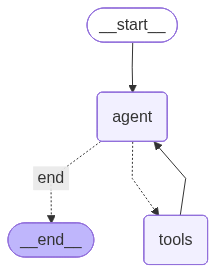

In [ ]:
from IPython.display import Image, display

png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [ ]:
from langchain_core.messages import HumanMessage

for chunk in graph.stream({'messages': [HumanMessage('3에다 5를 더하고 거기에 8을 곱하면?')]}, stream_mode='values') :
    chunk['messages'][-1].pretty_print()